## VGG16 Model

In [80]:
# preprocessing
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean #scaling options
import skimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# modeling 
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.utils import to_categorical
from keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def prep_pixels(train, test):
    train_norm = train.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
    return train_norm, test_norm
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    # save plot to file
    # plt.savefig('diagnostics/vgg16_diagnostic_plot_vl.png')
    # plt.close()
    
# run the test harness for evaluating a model
def run_test_harness(folder_name, epochs=100, batch_size=64, verbose=2, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)):
    # load dataset
    trainX, trainY, testX, testY, shape = load_server_dataset(folder_name, test_size=test_size, random_state=random_state, n=n, shape = shape)
    print('Dataset Loaded!')

    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    print('Dataset Preprocessed!')

    # define model
    print('Defining Model...')
    model = define_model(shape)

    # fit model
    print('Fitting model...')
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=verbose)
    print('Model fitted! Epochs=%d, Batch Size=%d' % (epochs, batch_size))
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=verbose)
    print('Model Evalution:')
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

    print('----FINISHED----')
    
    return model

In [81]:
def load_server_dataset(folder_name, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)):
    '''
    Given a folder name on Materiall's shared server:
    (1) read in all the files, 
    (2) convert them to pixels, 
    (3) separate them into train and testing data 
        (default test_size and random_state for reproducibility)
        TO_DO: need a better way to split so num_classes is the same in test/train

    Return: X_train, X_test, y_train, y_test, shape of each image
    '''

    # read in filelist and rename columns
    df = pd.read_csv(f'{folder_name}/filelist', sep=" ", header=None)
    df.columns = ['link', 'filepath', 'class', 'probability']

    # filter
    classes = ['living_room', 'house_view', 'kitchen', 'yard', 'garage']
    df = df[df['probability'] > 0.95]
    df = df[df['class'].isin(classes)]

    # change dataset size if specified
    if n > 0:
        df = df.sample(n)

    # add pixels column, resize images (not proportional)
    df['pixels'] = df['link'].apply(lambda x: resize(io.imread(x), shape)) #might take a while

    #split and return training and test sets
    X = np.array([x for x in df['pixels']])
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)

    # integer encode target labels so that keras can one hot
    label_encoder = LabelEncoder()
    vec_train = label_encoder.fit_transform(y_train)
    vec_test = label_encoder.fit_transform(y_test)

    # one hot encode target values
    y_train = to_categorical(vec_train)
    y_test = to_categorical(vec_test)

    #trainX, trainY, testX, testY 
    #(make sure ordering is correct to match harness function)
    return X_train, y_train, X_test, y_test, shape

In [82]:
# define cnn model
def define_model(shape=(32,32,3)):

    # grab the pre-trained VGG16 model, removing the top layers and changing the input shape
    model = VGG16(weights="imagenet", include_top=False, input_shape=shape)
        
    # freeze pre-trained layers
    for layer in model.layers:
        layer.trainable = False

    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(512, activation='relu')(flat1)
    class2 = Dense(512, activation='relu')(class1)
    output = Dense(5, activation='softmax')(class2)

    # define new model with top layers
    model = Model(inputs=model.inputs, outputs=output)
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # for output while training
    model.summary()

    return model

Dataset Loaded!
Dataset Preprocessed!
Defining Model...
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_______________________________________________________________

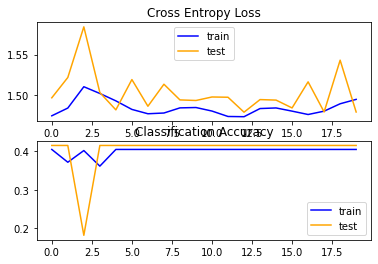

In [84]:
# optional params: epochs=100, batch_size=64, verbose=2, test_size=0.1, random_state=100, n=-1, shape = (100, 100, 3)
run_test_harness('fremont_dataset', epochs=20, shape=(100, 100, 3))

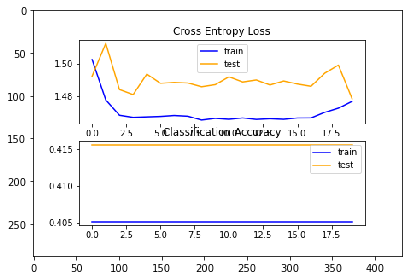

In [72]:
io.imshow('diagnostics/vgg16_diagnostic_plot_vl.png')